In [4]:
import time
import torch
import pandas as pd
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [5]:
df = pd.read_excel('Filtered.xlsx')

df_melted = pd.melt(df, id_vars=['xi'], 
                    value_vars=['BLOOM_complete', 'CTRL_complete', 'FLAN_complete', 'GPT2_complete', 'OPT_complete'],
                    var_name='Model', value_name='Generated_Sentence')

le = LabelEncoder()
df_melted['Model_encoded'] = le.fit_transform(df_melted['Model'])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [6]:
def encode_sentences(sentences, tokenizer, max_length=128):
    encodings = tokenizer(sentences.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='pt')
    return encodings['input_ids'], encodings['attention_mask']

class TextDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_masks': self.attention_masks[idx],
            'labels': self.labels[idx]
        }


In [7]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.model = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(768, len(le.classes_))
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.fc(self.dropout(pooled_output))
        return output


In [8]:
def train_and_get_predictions(model, train_loader, test_loader, epochs=3):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

    start_time = time.time()
    model.train()

    for epoch in range(epochs):
        loop = tqdm(train_loader, leave=True)
        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_masks'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loop.set_postfix(loss=loss.item())

    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_masks'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            predictions.append(preds.cpu().numpy())

    print(f"Training completed in {time.time() - start_time:.2f} seconds.")
    return np.hstack(predictions)


In [9]:
def print_results(y_test, predictions, title):
    acc = accuracy_score(y_test, predictions) * 100
    print(f"\n{title} Overall Accuracy: {acc:.2f}%")
    
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    for i, class_name in enumerate(le.classes_):
        if i in np.unique(predictions):
            class_acc = (predictions == y_test)[y_test == i].mean() * 100
            print(f"{class_name} Accuracy: {class_acc:.2f}%")


In [10]:
def prepare_data(df, excluded_model=None):
    if excluded_model:
        df_filtered = df[df['Model'] != excluded_model]
    else:
        df_filtered = df

    X = df_filtered['Generated_Sentence']
    y = df_filtered['Model_encoded']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_ids, X_train_masks = encode_sentences(X_train, tokenizer)
    X_test_ids, X_test_masks = encode_sentences(X_test, tokenizer)

    train_dataset = TextDataset(X_train_ids, X_train_masks, torch.tensor(y_train.values))
    test_dataset = TextDataset(X_test_ids, X_test_masks, torch.tensor(y_test.values))

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)

    return train_loader, test_loader, y_test


Training BERT model with all 5 LLMs...


  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

Training completed in 416.49 seconds.

BERT with all 5 LLMs Overall Accuracy: 53.10%


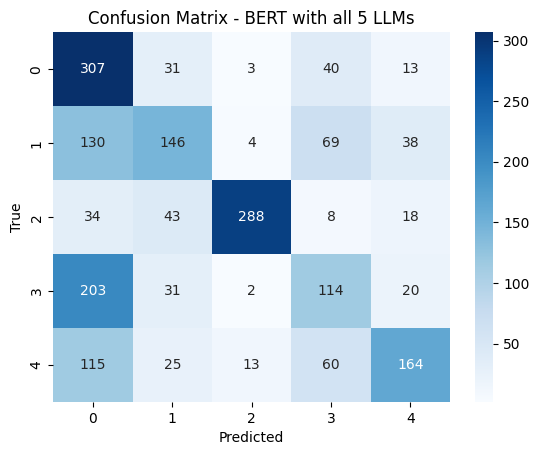

BLOOM_complete Accuracy: 77.92%
CTRL_complete Accuracy: 37.73%
FLAN_complete Accuracy: 73.66%
GPT2_complete Accuracy: 30.81%
OPT_complete Accuracy: 43.50%


In [11]:
print("Training BERT model with all 5 LLMs...")
train_loader, test_loader, y_test_full = prepare_data(df_melted)
bert_model = BaseModel()
bert_preds_full = train_and_get_predictions(bert_model, train_loader, test_loader)
print_results(y_test_full, bert_preds_full, "BERT with all 5 LLMs")



Training BERT and excluding BLOOM_complete...


  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

Training completed in 333.20 seconds.

BERT Excluding BLOOM_complete Overall Accuracy: 83.20%


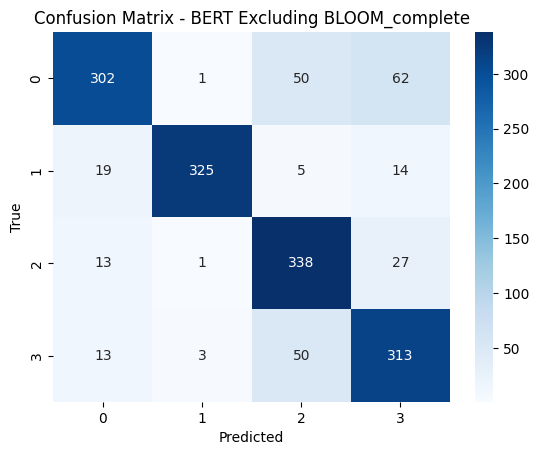

CTRL_complete Accuracy: 72.77%
FLAN_complete Accuracy: 89.53%
GPT2_complete Accuracy: 89.18%
OPT_complete Accuracy: 82.59%

Training BERT and excluding CTRL_complete...


  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

Training completed in 333.28 seconds.

BERT Excluding CTRL_complete Overall Accuracy: 73.18%


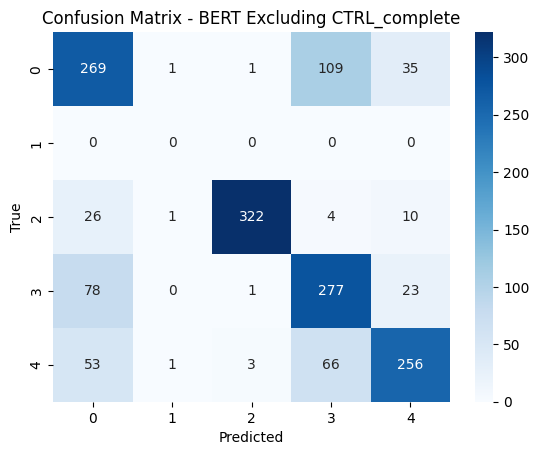

BLOOM_complete Accuracy: 64.82%
CTRL_complete Accuracy: nan%
FLAN_complete Accuracy: 88.71%
GPT2_complete Accuracy: 73.09%
OPT_complete Accuracy: 67.55%

Training BERT and excluding FLAN_complete...


  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

Training completed in 333.14 seconds.

BERT Excluding FLAN_complete Overall Accuracy: 72.20%


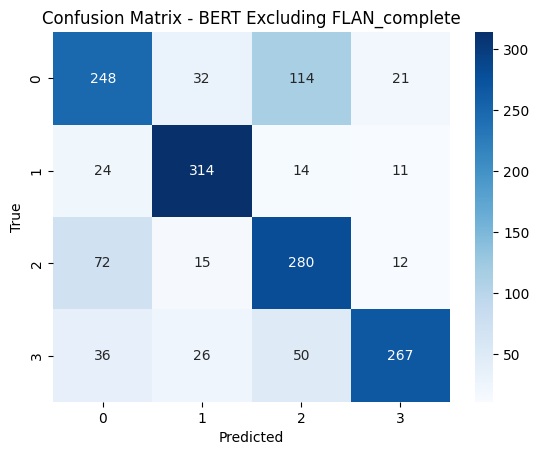

BLOOM_complete Accuracy: 59.76%
CTRL_complete Accuracy: 86.50%
GPT2_complete Accuracy: 73.88%
OPT_complete Accuracy: 70.45%

Training BERT and excluding GPT2_complete...


  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

Training completed in 333.19 seconds.

BERT Excluding GPT2_complete Overall Accuracy: 81.84%


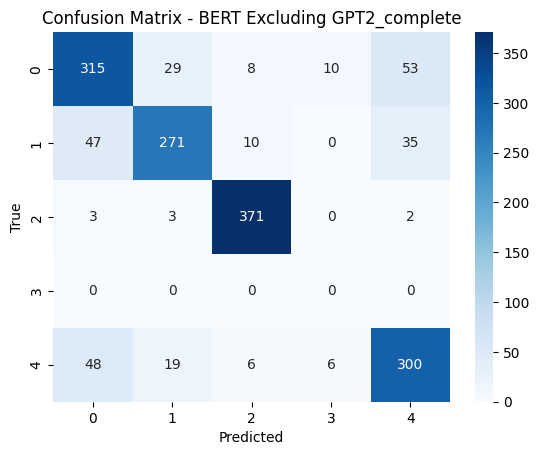

BLOOM_complete Accuracy: 75.90%
CTRL_complete Accuracy: 74.66%
FLAN_complete Accuracy: 97.89%
GPT2_complete Accuracy: nan%
OPT_complete Accuracy: 79.16%

Training BERT and excluding OPT_complete...


  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

Training completed in 333.31 seconds.

BERT Excluding OPT_complete Overall Accuracy: 84.24%


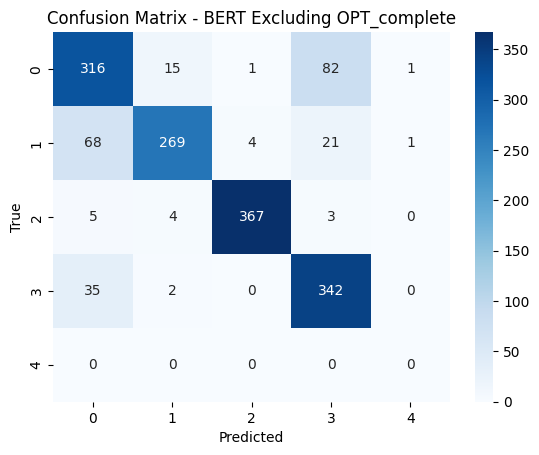

BLOOM_complete Accuracy: 76.14%
CTRL_complete Accuracy: 74.10%
FLAN_complete Accuracy: 96.83%
GPT2_complete Accuracy: 90.24%
OPT_complete Accuracy: nan%


In [12]:
llms_to_exclude = ['BLOOM_complete', 'CTRL_complete', 'FLAN_complete', 'GPT2_complete', 'OPT_complete']

for excluded_llm in llms_to_exclude:
    print(f"\nTraining BERT and excluding {excluded_llm}...")
    train_loader_excl, test_loader_excl, y_test_excl = prepare_data(df_melted, excluded_model=excluded_llm)
    bert_preds_excl = train_and_get_predictions(bert_model, train_loader_excl, test_loader_excl)
    print_results(y_test_excl, bert_preds_excl, f"BERT Excluding {excluded_llm}")


In [13]:
learning_rates = [1e-5, 2e-5, 3e-5]
best_accuracy = 0
best_lr = None

In [15]:
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    
    bert_model = BaseModel()
    bert_model.to(device)

    optimizer = torch.optim.Adam(bert_model.parameters(), lr=lr)
    
    bert_preds = train_and_get_predictions(bert_model, train_loader, test_loader, epochs=3)
    acc = accuracy_score(y_test_full, bert_preds) * 100
    print(f"Accuracy with lr={lr}: {acc:.2f}%")
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_lr = lr

print(f"Best learning rate: {best_lr} with accuracy {best_accuracy:.2f}%")


Training with learning rate: 1e-05


  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

Training completed in 416.35 seconds.
Accuracy with lr=1e-05: 52.63%
Training with learning rate: 2e-05


  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

Training completed in 416.55 seconds.
Accuracy with lr=2e-05: 53.93%
Training with learning rate: 3e-05


  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

Training completed in 416.42 seconds.
Accuracy with lr=3e-05: 54.61%
Best learning rate: 1e-05 with accuracy 85.46%
